# Before we start...
### Uncomment below to install cvxopt and qpsolvers

In [1]:
# !sudo CVXOPT_BUILD_GLPK=1 pip install cvxopt
# !pip install qpsolvers

     |████████████████████████████████| 121 kB 13.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 54 kB/s 
  Created wheel for quadprog: filename=quadprog-0.1.10-cp37-cp37m-linux_x86_64.whl size=290737 sha256=bb662568acbfa67c3f814b543f0355ba5318186ba95193be10e9f33e96ace996
  Stored in directory: /root/.cache/pip/wheels/e9/af/76/c5335ed32afc1284e6100b86588d1f75f5c4906fa26df6efda
Successfully built quadprog
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1

### Import some stuff

In [2]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.spatial import Delaunay, ConvexHull, convex_hull_plot_2d
from scipy.optimize import NonlinearConstraint, LinearConstraint, minimize
from typing import Tuple
import scipy.optimize as optimize
from scipy.optimize import linprog
from scipy.interpolate import interp1d
from qpsolvers import solve_qp
import quadprog
import cvxopt
from google.colab import files

# Learning in High Dimension Always Amounts to Extrapolation


---
---
Randall Balestriero, Jerome Pesenti, and Yann LeCun

Below I'll try to reproduce Figure 1 of [this paper](https://arxiv.org/pdf/2110.09485.pdf).

![im](https://drive.google.com/uc?export=view&id=16XZ8qW7h8-D-KqbUMBYi833TKupBzmte)

This plot has a lot going on, all of which I will try to explain below, namely:

- Ambient dimension $d$
- Probability of lying in the convex hull $p(x \in \text{Hull}(\mathbf{X}))$
- Number of hull data points $N$

And other things that aren't apparent directly from the image but do play a role:  

- Convex hull dimension $d^*$
- Intrinsic dimension $\bar{d}$

In normal(ish) words, what this plot is supposed to convey is that

***no matter the dimensionality of the manifold your data lies on, if you increase the dimensionality in which you represent your data, and with that the dimensionality of the interpolation regime of your data, you need exponentially more data points to keep the same probability of a new sample being an interpolation of the training samples.***

And then the rightmost plot shows that if you do keep the dimensionality of the interpolation regime of your data fixed, the probability of being in this regime stays the same for increased ambient dimension $d$.

Below we'll explain what is going on in the terminology of the paper.

# Reproducing the first plot
---
For the first plot (the leftmost in Figure 1) what the authors do is the following. 


They use 500,000 trials to estimate the probability of being in the convex hull for a new sample. In every trial, they sample $N$ times from a Gaussian density $\mathbf{x}_i \sim \mathcal{N}(0, \mathbb{I}_d)$; these samples will form the convex hull. Then, they sample a new data point from that Gaussian
and calculate whether it falls inside the convex hull (below we implement multiple ways to find out whether a point falls inside the convex hull). This will give in the end a vector of 500000 true's (inside the hull) and falses (outside the hull) that gives a probability.

What we will implement for the first figure below is the following:

- `sample_from_gaussian`: a function to sample from a multivariate Gaussian
- `is_in_convex_hull_batch`: returns vector of true's and falses that specify whether each sample in a batch of new vectors fall inside the convex hull
- `probability_in_convex_hull_batch`: returns the estimated probability that a new sample lies in the convex hull.

**CAVEAT**: since the code is already slow due to this convex hull calculation, we cheat the estimate slightly by only sampling the convex hull samples once, and then finding out whether all new vectors are in this convex hull at once.


In [7]:
def sample_from_gaussian(num_samples: int, num_dimensions: int, mu=0,
                         sigma=1) -> np.array:
  """
  Sample num_samples from a multivariate Gaussian with `num_dimensions`
  independent dimensions.

  Returns: [num_samples, num_dimensions] gaussian samples.
  """
  mu, sigma = np.zeros(num_dimensions) + mu, np.identity(num_dimensions) * sigma
  return np.random.multivariate_normal(mu, sigma, num_samples)

Plotting the data we see that everything is normally distributed.

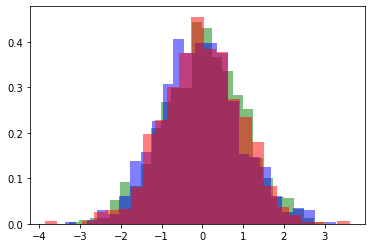

In [8]:
samples = sample_from_gaussian(1000, 3)
plt.hist(samples[:, 0], bins=25, density=True, alpha=0.5, color='g')
plt.hist(samples[:, 1], bins=25, density=True, alpha=0.5, color='b')
plt.hist(samples[:, 2], bins=25, density=True, alpha=0.5, color='r')
plt.show()

## Probability of lying in the convex hull
A vector $\mathbf{x}$ lies within the convex hull spanned by samples $\mathbf{x}_1, \dots, \mathbf{x}_N \in \mathbb{R}^d$ if we can write it as a convex combination of the samples $\mathbf{x} = \lambda_1\mathbf{x}_1 + \dots + \lambda_N\mathbf{x}_N$ subject to $\lambda_i \geq 0$ and $\sum_i \lambda_i = 1$.

Let's see what this means in a dimensionality that we can still visualize:

Below we can see a 2-dimensional convex hull for 4 samples, one point inside the hull,
and one point outside of the hull. The point inside the hull is a convex combination of the hull points, and the point outside the hull is an affine/linear combination.

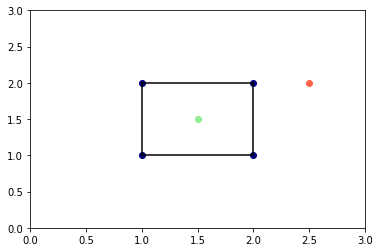

In [9]:
hull_samples = np.array([[1, 1],
                         [2, 1],
                         [2, 2],
                         [1, 2]])
                         
# Here's a point that is a convex combination of the hull samples ..
point_in_hull = np.array([[1.5, 1.5]])

# .. and here's one that isn't.
point_outside_hull = np.array([[2.5, 2]])

# Calculate the convex hull with scipy.spatial.ConvexHull
hull = ConvexHull(hull_samples)

# Let's plot it.
plt.plot(hull_samples[:, 0], hull_samples[:, 1], 'o', c='navy')
plt.plot(point_in_hull[:, 0], point_in_hull[:, 1], 'o', c='lightgreen')
plt.plot(point_outside_hull[:, 0], point_outside_hull[:, 1], 'o', c='tomato')
for simplex in hull.simplices:
  plt.plot(hull_samples[simplex, 0], hull_samples[simplex, 1], 'k')

plt.xlim(0, 3)
plt.ylim(0, 3)
plt.show()

So let's say we sample points uniformly between 0 and 3 for both dimensions, then the probability of a new sample to lie within the convex hull from this subspace is the area of the convex hull divided by the total area:

$p(\mathbf{y} \in \text{Hull}(\mathbf{X})) = \frac{1}{9}$.

In general, for a convex hull with area $c$ in $\mathbb{R}^2$ and data points between $[x_0, x_1]$ the probability of lying in the convex hull is $\frac{c}{(x_1 - x_0)^2}$.

## The Curse of Dimensionality

Now let's move to 3 dimensions, and stretch the convex hull out in the Z-direction to get a cube instead of the square above.

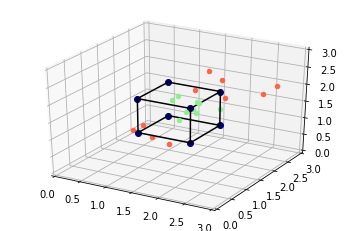

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Make the cube of 3D hull points (8 points, each is a corner of the cube).
X = np.array([1, 2, 2, 1, 1, 2, 2, 1])
Y = np.array([1, 1, 2, 2, 1, 1, 2, 2])
Z = np.array([1, 1, 1, 1, 2, 2, 2, 2])

# Set the same limits as the 2D example.
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_zlim(0, 3)

# A function to get a convex combination of a set of points.
def convex_combination(points):
  lambdas = np.random.randint(0, 10, len(points))
  lambdas_n = lambdas / np.sum(lambdas)
  return np.dot(points.transpose([1, 0]), lambdas_n)

# A function to get an affine combination of a set of points 
# that is *not* a convex combination.
def affine_combination(points):
  lambdas = np.random.randint(0, 10, len(points))
  lambdas_n = lambdas / np.sum(lambdas)
  offset = np.random.choice([np.random.uniform(-0.1, -0.02),
                             np.random.uniform(0.02, 0.1)])
  lambdas_n = lambdas_n + offset
  return np.dot(points.transpose([1, 0]), lambdas_n)

# Plot some convex combinations of the hull data points.
for i in range(10):
  num_points = np.random.randint(5, 8, 1)
  point_indices = np.random.randint(0, 8, num_points)
  points = np.array([X[point_indices], 
                     Y[point_indices], 
                     Z[point_indices]]).transpose([1, 0])
  new_point = convex_combination(points)
  ax.scatter(*new_point, c='lightgreen', zorder=2.5)

# Plot some affine combinations of the hull data points.
for i in range(10):
  num_points = np.random.randint(5, 8, 1)
  point_indices = np.random.randint(0, 8, num_points)
  points = np.array([X[point_indices], 
                     Y[point_indices], 
                     Z[point_indices]]).transpose([1, 0])
  new_point = affine_combination(points)
  ax.scatter(*new_point, c='tomato', zorder=12.5)

# Plot the box around the convex hull.
ax.plot(X, Y, Z, 'o', c='navy', zorder=7.5)
for i in range(4):
  idx = i
  idx_right = (idx + 1) % 4
  ax.plot([X[idx], X[idx_right]],
          [Y[idx], Y[idx_right]],
          [Z[idx], Z[idx_right]], color = 'k', zorder=10)
  ax.plot([X[idx+4], X[idx_right+4]],
          [Y[idx+4], Y[idx_right+4]],
          [Z[idx+4], Z[idx_right+4]], color = 'k', zorder=10)
  ax.plot([X[idx], X[idx_right+3]],
          [Y[idx], Y[idx_right+3]],
          [Z[idx], Z[idx_right+3]], color = 'k', zorder=10)
plt.show()

This cube still has a volume of 1, but now the probability of lying within this cube has become:

$p(\mathbf{y} \in \text{Hull}(\mathbf{X})) = \frac{1}{27}$

In general, for a convex hull with area $c$ in $\mathbb{R}^3$ and data points between $[x_0, x_1]$ the probability of lying in the convex hull is $\frac{c}{(x_1 - x_0)^3}$. This gives part of the intuition as to why the probability of lying within the convex hull quickly goes down as the dimensionality of the problem goes up.

This intuition is formalized in the paper by a theorem describing the limiting behaviour of the probability of lying in
 the convex hull for new (i.i.d.) samples from a Gaussian.

**Theorem 1** (Baranay and Furedi, 1988). Given a $d$-dimensional dataset 
$\mathbf{X} \triangleq \{\mathbf{x}_1, \dots, \mathbf{x}_N\}$ with i.i.d. samples $\mathbf{x}_n \sim \mathcal{N}(0, \mathbb{I}_d)$,
for all $n$, the probability that a new sample $\mathbf{x} \sim \mathcal{N}(0, \mathbb{I}_d)$ is in interpolation regime
(recall Def. 1) has the following limiting behavior

$$\lim_{d \rightarrow \infty} p(\mathbf{x} \in \text{Hull}(\mathbf{X})) = \begin{cases} 
      1 & \text{if } N > d^{-1}2^{d/2} \\
      0 & \text{if } N < d^{-1}2^{d/2} 
   \end{cases}
$$

This theorem says that the probability that a new sample lies in the convex hull of $N$ samples  
 tends to one for increasing dimensions if $N > d^{-1}2^{d/2}$, but if $N$ is smaller, it tends to 0. This means
we need to exponentially increase the number of datapoints $N$ for increasing $d$ if we want to have a chance at 
being in interpolation regime. See below this boundary of minimal $N$ needed
 plotted ($N = d^{-1}2^{d/2}$).

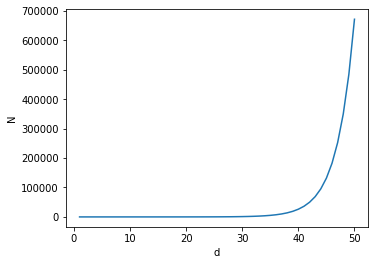

In [12]:
d = np.linspace(1, 50)

def need_number_datapoints(d: np.array):
  return (1 / d) * 2**(d / 2)

plt.plot(d, need_number_datapoints(d))
plt.xlabel("d")
plt.ylabel("N")
plt.subplots_adjust(left=0.2)
plt.show()

## Does a new point lie in the convex hull?

Now to find out whether a new point $\mathbf{x}$ is in the convex hull we just need to find out whether it is a convex combination of the hull samples, which can be framed as a quadratic programming problem, which we will do for the second plot below, but for the first plot we can use a very simple batched implementation using SciPy. The QP problem is necessary for the second plot since the method used below does not work for degenerate convex hull spaces, which will be the case for the second plot (lower intrinsic dimension than ambient dimension).

Below we use a batched implementation of finding whether points lie in the convex hull by relying on [scipy.Delaunay](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html).

In [13]:
def is_in_convex_hull_batch(new_samples: np.array, 
                            hull_samples: np.array) -> np.array:
  """
  Returns a vector of size new_samples.shape[0] (the number of new samples),
  with a boolean indicating whether or not the sample lies in the convex hull.
  """
  assert new_samples.shape[1] == hull_samples.shape[1],  \
  "Dimensions of new sample and convex hull samples should be the same, "
  "but are %d and %d" % (new_samples.shape[1], samples.shape[1])
  if not isinstance(hull_samples, Delaunay):
    hull = Delaunay(hull_samples)
  return hull.find_simplex(new_samples) >= 0

def probability_in_convex_hull_batch(new_samples: np.array, 
                                     hull_samples: np.array) -> float:
  """
  The first dimension is the number of new samples, the second dimension
  is the dimensionality of the vector.
  """
  in_convex_hull = is_in_convex_hull_batch(new_samples, hull_samples)
  return np.sum(in_convex_hull) / new_samples.shape[0]

Let's see if it works for the 2D hull we defined above. In addition to the point inside and the point outside the hull above, let's add 2 more points outside the hull to get a probability of being inside the hull of $\frac{1}{4}$.

In [14]:
point_in_hull = np.array([1.3, 1.8])
point_outside_hull = np.array([3, 2])
point_outside_hull_2 = np.array([4, 2])
point_outside_hull_3 = np.array([0, 2])
points = np.concatenate([np.expand_dims(point_in_hull, axis=0),
                         np.expand_dims(point_outside_hull, axis=0),
                         np.expand_dims(point_outside_hull_2, axis=0),
                         np.expand_dims(point_outside_hull_3, axis=0)], axis=0)
print("Probability inside hull (batch method): ", 
      probability_in_convex_hull_batch(points, hull_samples))

Probability inside hull (batch method):  0.25


## Reproducing the plot

Now let's try to reproduce the left plot of Figure 1. To do this,
we sample $N$ points for an ambient dimension $d$ from a multivariate Gaussian $\mathcal{N}(\mathbf{0}, \mathbb{I}_d)$. These points form the convex hull. Then we sample 500000 new points (`num_trials`) from the same Gaussian, and see whether they fall within the hull, or outside, to estimate the probability of being inside the convex hull.

We do this for different $N$ per dimensions $d \in \{2, \dots, 7\}$. The N below (in `num_convex_hull_samples_per_dim`) are chosen to roughly be the same as in the plot (I eyeballed it).

**NB**: note that the code below runs reasonably quick for dimensions 2 to 6, but takes a few minutes for dimensions = 7.

In [15]:

# The different ambient dimensions that we will consider.
ambient_dimensions = list(range(2, 8))

# The different values for N that we will consider.
num_dataset_sizes = 10
num_convex_hull_samples_per_dim = [np.logspace(0.5, 1.8, num_dataset_sizes),
                                   np.logspace(1, 2, num_dataset_sizes),
                                   np.logspace(1.2, 2.1, num_dataset_sizes),
                                   np.logspace(1.5, 2.2, num_dataset_sizes),
                                   np.logspace(2, 2.5, num_dataset_sizes),
                                   np.logspace(2.1, 3, num_dataset_sizes)]
num_trials = 500000

def get_convex_hull_probability_gaussian(num_trials: int, dataset_size: int, 
                                         ambient_dimension: int) -> float:
  """Samples `dataset_size` samples from a Gaussian of dimension 
  `ambient_dimension`, and then calculates for `num_trials` new samples
  whether they lie on the convex hull or not. Returns the estimated
  probability that a new sample lies in the convex hull."""
  convex_hull_samples =  sample_from_gaussian(num_samples=dataset_size, 
                                              num_dimensions=ambient_dimension)
  new_samples = sample_from_gaussian(num_samples=num_trials, 
                                     num_dimensions=ambient_dimension)
  p_new_samples_in_hull = probability_in_convex_hull_batch(
      new_samples=new_samples, hull_samples=convex_hull_samples)
  return p_new_samples_in_hull

# For each ambient dimension d, get the probability that a new sample lies in
# the convex hull per value for N.
all_probabilities = np.zeros([len(ambient_dimensions),
                              num_dataset_sizes])
for dimension_idx, dimension in enumerate(ambient_dimensions):
  print("Working on %d-D" % dimension)
  num_convex_hull_samples = num_convex_hull_samples_per_dim[dimension_idx]
  for size_idx, dataset_size in enumerate(num_convex_hull_samples):
    probability_in_hull = get_convex_hull_probability_gaussian(
        num_trials, int(dataset_size), dimension)
    all_probabilities[dimension_idx, size_idx] = probability_in_hull

Working on 2-D
Working on 3-D
Working on 4-D
Working on 5-D
Working on 6-D
Working on 7-D


Now we can reproduce the left plot in Figure 1 with the code below.

In [17]:
def plot_probabilities(x_space_per_dimension, dimensions, probabilities):
  """
  x_space_per_dimension: [len(dimensions)] an np.logspace per dimension
  dimensions: the different dimensions to be plotted on the Y-axis
  probabilities: [num_dimensions, num_dataset_sizes] convex hull probabilities
  """
  num_dimensions = len(dimensions)
  fig = plt.figure()

  # All stacked plots equally high.
  gridspecs = gridspec.GridSpec(num_dimensions, 1, 
                                height_ratios=[1] * num_dimensions) 

  # Loop over the grids and plot the probabilities for a dimension in each.
  colors = ["b", "orange", "g", "r", "purple", "brown"]
  for i, ax in enumerate(reversed(list(gridspecs))):
    x = x_space_per_dimension[i]
    ax = plt.subplot(ax)
    ax.set_xscale("log")
    ax.set_xlim(1, 10**3)  # Hardcode the limits for each subplots here.
    ax.scatter(x, probabilities[i], color=colors[i])
    ax.set_ylim(0, 1)

    # Only add the Y tick for p=1 at the topmost subplot.
    if i < (dimensions[-1] - dimensions[0]):
      ax.set_yticks([0, 0.5], minor=False)
    else:
      ax.set_yticks([0, 0.5, 1], minor=False)
    
    # Only add the X ticks for the bottom subplot.
    if i != 0:
      ax.set_xticks([])
    else:
      ax.set_xlabel('log(N)', fontsize = 12)
      ax.xaxis.set_label_coords(0.5, -0.655)

    # Some annotations
    plt.axhline(y=0.5, color='black', linestyle='--')
    plt.text(10**3+500,0.5,'d=%d' % dimensions[i] ,rotation=0)

  # remove vertical gap between subplots
  plt.ylabel("p(x in Hull)", fontsize=12)
  plt.subplots_adjust(hspace=.0)

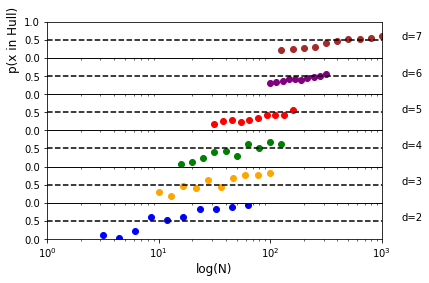

In [18]:
plot_probabilities(x_space_per_dimension=num_convex_hull_samples_per_dim,
                   dimensions=ambient_dimensions,
                   probabilities=all_probabilities)
plt.show()

# Reproducing the second plot
---

Now let's reproduce the second plot in Figure 1. For this we want to sample from a nonlinear continuous 1-dimensional data manifold, but we want to increase
the ambient dimension. 

To get a 1D nonlinear continuous manifold that will have an ambient dimension of $d$ we take the following steps:

- Sample $d$ independent Gaussian points.
- Interpolate between these points with a spline to get a 1D data manifold.
- Sample from a uniform distribution between 0 and 1 and put these through the spline to get our samples.

These samples are now taken from a spline $f: \mathbb{R} \rightarrow \mathbb{R}^{d}$, meaning the ambient dimension will be $d$, whereas the intrinsic dimension is 1.

**Why would this work?**

This works because the chances of sampling a point from a Gaussian that's overlapping with a previous point is zero,
so with every point that we sample we increase the dimensionality the spline moves through.

Let's implement it below.


In [16]:
def construct_one_dimensional_manifold(ambient_dimension: int):
  """
  ambient_dimension: what dimension should the data be represented in

  Returns: The spline function f: R -> R^ambient_dimension.
  """
  # We take dimensions+2 for the dimension of the Gaussian because otherwise 
  # the scipy interp1d function doesn't work.
  gaussian_points = sample_from_gaussian(num_samples=ambient_dimension, 
                                         num_dimensions=ambient_dimension+2)
  x = np.linspace(0, 1, num=ambient_dimension+2, endpoint=True)
  f = interp1d(x, gaussian_points, kind='cubic')
  return f

def sample_from_one_dimensional_manifold(manifold_func, num_samples):
  return manifold_func(np.random.uniform(low=0, high=1, size=num_samples))

See below what this looks like for a 1D manifold with a 2D convex hull. You can change the convex hull dimension below to see that if you increase it to, say, 10, the spline looks much more wobbly.

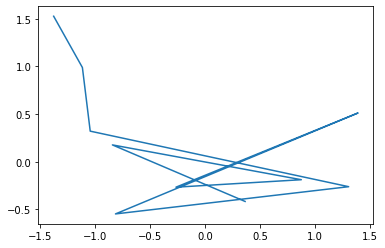

In [19]:
spline = construct_one_dimensional_manifold(ambient_dimension=10)

# Plot some samples from this manifold.
x = np.linspace(0, 1, num=10, endpoint=True)
plt.plot(spline(x)[0, :], spline(x)[1, :])
plt.show()

# Does it lie in the convex hull? A QP problem

Unfortunately, the batched method for finding out whether a new point lies inside the convex hull doesn't work anymore. This is because the fact that our samples all come from a 1D manifold causes geometric degeneracy. From the scipy docs:

```QhullError 
Raised when Qhull encounters an error condition, such as geometrical degeneracy when options to resolve are not enabled.```

Instead, we will frame it as a quadratic programming problem and solve it with a GP solver that can handle degeneracy. 

We want to find the coefficients such that $\lambda_1 \mathbf{x}_1 + \dots + \lambda_N \mathbf{x}_N = \mathbf{y}$, which would mean the new point $\mathbf{y}$ lies in the convex hull. Ofcourse, the constraints on the $\lambda$'s also need to be taken care of. If we cannot find these coefficients, then the point does not lie on the convex hull.


Let's define the following:
- $N$ the number of convex hull samples
- $d^*$ the dimension of the convex hull (in this case equals the ambient dimension)
- $\boldsymbol{\lambda} \in \mathbb{R}^{N}$ the convex combination coefficients
- the convex hull samples $\mathbf{X} \in \mathbb{R}^{N \times d}$
- the new sample $\mathbf{y} \in \mathbb{R}^d$

Our quadratic program problem is the following:

$$\begin{align}
\text{min}_{\boldsymbol{\lambda}} &\left(\mathbf{X}^T\boldsymbol{\lambda} - \mathbf{y}\right)^T \left(\mathbf{X}^T\boldsymbol{\lambda} - \mathbf{y}\right) \\
s.t. & \sum_i \lambda_i = 1 \\
& \lambda_i \geq 0 
\end{align}$$

We can rewrite the objective to the [standard form](https://scaron.info/blog/quadratic-programming-in-python.html) as follows:

$$\begin{align}
\text{min}_{\boldsymbol{\lambda}} &\frac{1}{2}\boldsymbol{\lambda}^T(\mathbf{X}\mathbf{X}^T)\boldsymbol{\lambda} + (-\mathbf{X}\mathbf{y})^T\boldsymbol{\lambda}
\end{align}$$

(the above follows from the fact that multiplying by a constant doesn't change the objective, and neither does a constant addition)

Then to rewrite the inequality constraints into the form $G\boldsymbol{\lambda} \leq h$,
we make the matrix G as follows:

$G = \begin{pmatrix}
-1 & 0 & 0 & 0 \\ 
0 & -1 & 0 & 0\\ 
0 & 0 & -1 & 0\\ 
0 & 0 & 0 & -1
\end{pmatrix}$

and the vector h:

$
h = \begin{pmatrix}
0\\ 
0\\ 
0\\ 0
\end{pmatrix}
$

And the equality constraint into the form $A\lambda = b$ as follows:

$A = \begin{pmatrix}
1 & 1 & 1 & 1 \\ 
\end{pmatrix}$

and the vector b:

$
b = \begin{pmatrix}
1
\end{pmatrix}
$

This ensures that the sum of the $\lambda_i$ equals 1 and all entries are above nonnegative.

Below we implement this, and we assume a new vector is in the complex hull if the QP problem has a loss smaller than 1e-5.

Note the definitions of the following variables in the code below to keep it the same as in [the example](https://scaron.info/blog/quadratic-programming-in-python.html) that I used.
- $\mathbf{P} := \mathbf{X}\mathbf{X}^T$
- $\mathbf{q} := -\mathbf{X}\mathbf{y}$

In [24]:
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
  "Copied from https://scaron.info/blog/quadratic-programming-in-python.html"
  P = .5 * (P + P.T)  # make sure P is symmetric
  args = [cvxopt.matrix(P), cvxopt.matrix(q)]
  if G is not None:
      args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
      if A is not None:
          args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
  sol = cvxopt.solvers.qp(*args)
  if 'optimal' not in sol['status']:  # Failed
      return np.array([-10] * P.shape[1]).reshape((P.shape[1],))
  return np.array(sol['x']).reshape((P.shape[1],))
  
def is_in_convex_hull_qp(new_sample: np.array, hull_samples: np.array) -> bool:
  """
  :param new_sample: [num_dimensions]
  :param hull_samples: [num_hull_samples, num_dimensions]

  Calcs for `new_sample` whether it lies in the convex hull of `hull_samples`.
  """
  num_hull_samples = len(hull_samples)
  num_dimensions = len(new_sample)

  # Define the QP problem.
  P = np.dot(hull_samples, hull_samples.T).astype(np.double)
  q = -np.dot(hull_samples, new_sample).astype(np.double)

  G = -np.identity(num_hull_samples)
  h = np.array([0] * num_hull_samples).astype(np.double)

  A = np.ones([1, num_hull_samples]).astype(np.double)
  b = np.array([1]).astype(np.double)

  result = cvxopt_solve_qp(P, q, G, h, A, b)

  def loss(l_i, sign=1., y=new_sample, X=hull_samples):
    return sign * np.dot((y - np.dot(X.T, l_i)).T, (y - np.dot(X.T, l_i)))

  l = loss(result)
  if l < 1e-5:
    return True
  else:
    return False

def probability_in_convex_hull_qp(new_samples: np.array, 
                                  hull_samples: np.array) -> float:
  """
  The first dimension is the number of new samples, the second dimension
  is the dimensionality of the sample. Returns the estimated probability
  that a new sample lies in the convex hull of `hull_samples`.
  """
  in_convex_hull = np.zeros([new_samples.shape[0]])
  for i in range(len(new_samples)):
    new_sample = new_samples[i, :]
    vec_in_convex_hull = is_in_convex_hull_qp(new_sample, hull_samples)
    in_convex_hull[i] = vec_in_convex_hull
  return np.sum(in_convex_hull) / new_samples.shape[0]

Let's test it for the example points and convex hull that we also used below (probability should be $\frac{1}{4}$).

In [25]:
print("Probability inside hull (quadratic programming method): ", probability_in_convex_hull_qp(points, hull_samples))

Probability inside hull (quadratic programming method):  0.25


So let's reproduce the figure. Below we sample a new spline for every ambient dimension $d = \{2, \dots, 7\}$, and then for 10 different $N$ we sample from this same spline the convex hull samples and the new vectors. We see whether these new vectors are in the convex hull with QP and calculate the probability.

**CAVEAT**: The code below is *incredibly* slow, because of the new method of finding whether a point is in the convex hull used; framing it as a QP problem. The paper does 500000 trials, but below we do just 100, to be a bit faster (runs in a few minutes). It still works, but obviously the estimate is much worse.

In [30]:
ambient_dimensions = list(range(2, 8))
num_dataset_sizes = 10
num_convex_hull_samples_per_d = [np.logspace(0.5, 1.8, num_dataset_sizes),
                                 np.logspace(1, 2, num_dataset_sizes),
                                 np.logspace(1.2, 2.1, num_dataset_sizes),
                                 np.logspace(1.5, 2.2, num_dataset_sizes),
                                 np.logspace(2, 2.5, num_dataset_sizes),
                                 np.logspace(2.1, 3, num_dataset_sizes)]

num_trials = 100

def get_convex_hull_probability(manifold_spline, num_trials: int, 
                                dataset_size: int, 
                                ambient_dimension: int) -> float:
  # Get the samples to form the convex hull.
  hull_samples = manifold_spline(np.random.uniform(low=0, high=1,
                                                   size=dataset_size))

  # Get new samples from the manifold.                          
  new_samples = manifold_spline(np.random.uniform(low=0, high=1,
                                                  size=num_trials))

  # Estimate the probability that a new sample lies in the convex hull.
  p_new_samples_in_hull = probability_in_convex_hull_qp(
      new_samples=new_samples.transpose(),
      hull_samples=hull_samples.transpose())
  return p_new_samples_in_hull

# Loop over all ambient dimensions.
all_probabilities_2 = np.zeros([len(ambient_dimensions),
                                num_dataset_sizes])
for dimension_idx, dimension in enumerate(ambient_dimensions):
  print("Working on %d-D" % dimension)
  dataset_sizes = num_convex_hull_samples_per_d[dimension_idx]

  # Sample a new spline for this ambient dimension.
  spline = construct_one_dimensional_manifold(ambient_dimension=dimension)

  # Loop over the different dataset sizes.
  for size_idx, dataset_size in enumerate(dataset_sizes):

    # Estimate the probability
    probability_in_hull = get_convex_hull_probability(spline, num_trials,
                                                      int(dataset_size),
                                                      dimension)
    all_probabilities_2[dimension_idx, size_idx] = probability_in_hull

Working on 2-D
Working on 3-D
Working on 4-D
Working on 5-D
Working on 6-D
Working on 7-D


Let's plot it.

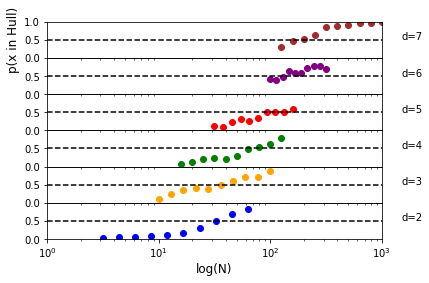

In [33]:
plot_probabilities(num_convex_hull_samples_per_d, 
                   ambient_dimensions, 
                   all_probabilities_2)
plt.show()

So now we see, even though our data points are all sampled from a 1D data manifold, namely a spline, because the actual ambient dimension still goes up, to keep the probability of sampling a point within the convex hull the same you need to again get exponentially more data.

# Reproducing the third plot

The final plot requires the introduction of some new terminology; it's the plot that answers the question: 
"so how can we control the probability of interpolating, i.e. of a new sample lying in the convex hull"? 
The answer is (somewhat unsurprisingly now); by keeping the *dimensions of the convex
hull* the same. The convex hull dimension, also referred to as the dimension of the lowest dimensional affine
subspace including the entire data manifold in the paper, is the dimension of the convex hull of the data points.
Recall the discussion of what the convex hull is above? Imagine if you take two datapoints, that happen
to lie on a line in $\mathbb{R}^3$. The ambient dimension is 3, but the convex hull dimension is 1; it's a line.
If we take 4 points that lie on a plane, we have ambient dimension of 3 and convex hull
dimension of 2. Finally, if we take the full set of 8 data points, like the plot below, we get a convex hull dimension of 3, which equals
 the ambient dimension. This convex hull dimension is denoted by $d^*$ in the paper.

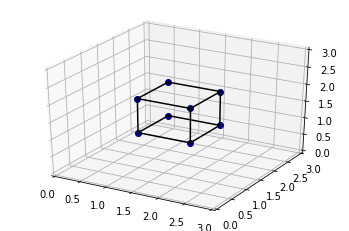

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')

X = np.array([1, 2, 2, 1, 1, 2, 2, 1])
Y = np.array([1, 1, 2, 2, 1, 1, 2, 2])
Z = np.array([1, 1, 1, 1, 2, 2, 2, 2])

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_zlim(0, 3)

# Plot the box around the convex hull.
ax.plot(X, Y, Z, 'o', c='navy', zorder=7.5)
for i in range(4):
  idx = i
  idx_right = (idx + 1) % 4
  ax.plot([X[idx], X[idx_right]],
          [Y[idx], Y[idx_right]],
          [Z[idx], Z[idx_right]], color = 'k', zorder=10)
  ax.plot([X[idx+4], X[idx_right+4]],
          [Y[idx+4], Y[idx_right+4]],
          [Z[idx+4], Z[idx_right+4]], color = 'k', zorder=10)
  ax.plot([X[idx], X[idx_right+3]],
          [Y[idx], Y[idx_right+3]],
          [Z[idx], Z[idx_right+3]], color = 'k', zorder=10)
plt.show()

For the third plot, we want to keep the convex hull dimensions the same, namely
a 4D Gaussian like in the paper,
but increase only the ambient dimension. To increase the ambient dimension without increasing the convex hull dimension, we can simply multiply the data points of a lower dimension with an invertible matrix of the desired dimension. This way we won't increase the convex hull dimension (since $rank(AB) = \min(rank(A), rank(B))$), but we will increase the ambient dimension. We're basically just embedding a 4D gaussian into a higher dimensional space.

To get a random invertible matrix of $d\times d$ we just sample $d$ times from a $d$-dimensional Gaussian again, which roughly guarantees to give an invertible matrix (with the same intuition as above; it's unlikely you'll sample a linearly dependent point).

In [28]:
def is_invertible(matrix: np.array):
  assert matrix.shape[0] == matrix.shape[1], "Non-square matrix cannot be " \
  "invertible."
  if np.linalg.cond(matrix) < 1 / sys.float_info.epsilon:
    return True
  else:
    return False

def get_invertible_matrix(num_dimensions: int):
  matrix = sample_from_gaussian(num_dimensions, num_dimensions)
  if is_invertible(matrix):
    return matrix
  else:
    raise ValueError("Sampled non-invertible matrix.")

def make_d_dimensions(samples: np.array, invertible_matrix: np.array,
                      new_dimensions: int) -> np.array:
  """
  samples: [num_samples, num_dimensions]
  invertible_matrix: [new_dimensions, new_dimensions]
  new_dimensions: the number of output dimensions

  Uses an invertible matrix to project input samples into a higher dimensional
  space.
  
  Returns: 
    [num_samples, new_dimensions] the new samples in a higher dimension
    [new_dimensions, new_dimensions] the transformation matrix used
  """
  assert len(samples.shape) == 2, "Need 2D matrix for argument 'samples'."
  assert new_dimensions > samples.shape[1], \
  "Cannot increase to %d dimensions if existing dimensions is %d" % (
      new_dimensions, samples.shape[1])
  existing_dimensions = samples.shape[1]
  extra_dimensions = new_dimensions - existing_dimensions
  
  # We add columns of zeros to the samples to be able to multiple
  # them with the right dimension invertible matrix.
  add_zeros = np.zeros([samples.shape[0], extra_dimensions])
  concat_samples = np.concatenate([samples, add_zeros], axis=1)
  
  # Transform the samples into a higher-dimensional space.
  new_samples = np.dot(concat_samples, invertible_matrix)
  
  # Check that we can recover the old samples.
  old_samples_recovered = np.dot(new_samples, np.linalg.inv(invertible_matrix))
  assert np.allclose(old_samples_recovered, concat_samples)
  
  return new_samples

def sample_4d_gaussian(num_samples: int, invertible_matrix: np.array,
                       ambient_dimension: int):
  """Samples data with a convex hull dimension of 4 and an ambient dimension
  of `ambient_dimension`."""
  gaussian_samples = sample_from_gaussian(num_samples=num_samples, 
                                          num_dimensions=4)
  return make_d_dimensions(gaussian_samples, invertible_matrix, 
                           new_dimensions=ambient_dimension)

With the above code we can sample from a 4D Gaussian and embed the points into a higher dimensional space. So now we can reproduce the third plot.

In [29]:
ambient_dimensions = list(range(5, 8))
num_dataset_sizes = 10
num_convex_hull_samples_per_d = [np.logspace(1, 2, num_dataset_sizes),
                                 np.logspace(1, 2, num_dataset_sizes),
                                 np.logspace(1, 2, num_dataset_sizes)]

num_trials = 1000

def get_convex_hull_probability(num_trials: int, dataset_size: int, 
                                ambient_dimension: int) -> float:
  # Sample the invertible matrix for this ambient dimension.
  matrix = get_invertible_matrix(ambient_dimension)
  
  # Get the convex hull samples of.
  hull_samples = sample_4d_gaussian(num_samples=dataset_size, 
                                    invertible_matrix=matrix,
                                    ambient_dimension=ambient_dimension)
  
  # Get the new samples.
  new_samples = sample_4d_gaussian(num_samples=num_trials, 
                                   invertible_matrix=matrix,
                                   ambient_dimension=ambient_dimension)
  
  # Estimate the probability of lying in the convex hull.
  p_new_samples_in_hull = probability_in_convex_hull_qp(
      new_samples=new_samples,
      hull_samples=hull_samples)
  return p_new_samples_in_hull

all_probabilities_3 = np.zeros([len(ambient_dimensions),
                                num_dataset_sizes])
for dimension_idx, dimension in enumerate(ambient_dimensions):
  print("Working on %d-D" % dimension)
  dataset_sizes = num_convex_hull_samples_per_d[dimension_idx]
  for size_idx, dataset_size in enumerate(dataset_sizes):
    probability_in_hull = get_convex_hull_probability(num_trials,
                                                      int(dataset_size),
                                                      dimension)
    all_probabilities_3[dimension_idx, size_idx] = probability_in_hull

Working on 5-D
Working on 6-D
Working on 7-D


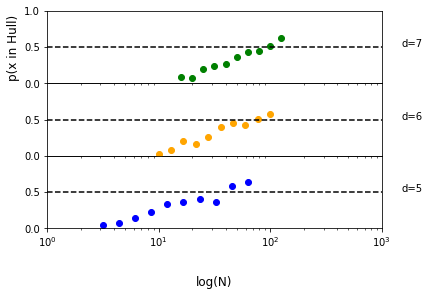

In [36]:
plot_probabilities(num_convex_hull_samples_per_d, 
                   ambient_dimensions, 
                   all_probabilities_3)
plt.show()